In [4]:
import sys

from pathlib import Path
ROOT_PATH = Path.cwd().parent

# To access packages and files from root directory
sys.path.insert(1, str(ROOT_PATH))

In [5]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX version: 0.3.13
Numpyro version: 0.9.2


In [6]:
numpyro.set_host_device_count(4)
jax.local_device_count()

4

In [7]:
FIG_PATH = Path.cwd() / 'figures/1DGP_figures'
FIG_PATH.mkdir(exist_ok=True, parents=True)

PUBLICATION_PATH = FIG_PATH / 'VGAE_L2G_print'
PUBLICATION_PATH.mkdir(exist_ok=True)

DATASET_PATH = ROOT_PATH / 'dataset.nosync'
DATASET_PATH.mkdir(exist_ok=True)

In [8]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [9]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400
  
@dataclass
class Args:
  batch_size: int = 100
  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 10_000 # 500_000
  eval_frequency: int = 50
  learning_rate: float = 1e-3
  xi: float = 1e2
  
  # Model params
  hidden_gnn_dim: int = 6
  hidden_fc_dim: int = 0
  latent_dim: int = 10  # 30
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP1D_ARGS = GP1DArgs()
ARGS = Args()

In [10]:
model_name = (
    f'PriorVGAE_asymmetric_1DGP_batched_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'xi{ARGS.xi}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}_'
    f'numLocations{GP1D_ARGS.num_locations}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\xi = {ARGS.xi}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    f'\n num_loc = {GP1D_ARGS.num_locations}'
    ')'
)

print(model_name)

PriorVGAE_asymmetric_1DGP_batched_lr0.001_epochs10000_xi100.0_gnn6_fc0_z10_numLocations400


# Dataset: GP priors to be encoded

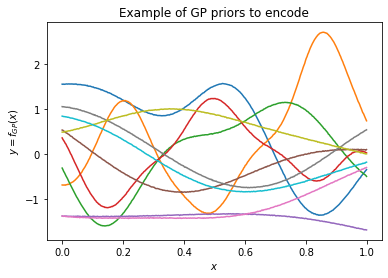

In [11]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)

num_to_plot = 10
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP1D_ARGS.kernel)

plotting.plot_gp_draws(
    X, gp_draws,
    num_draws_to_plot=num_to_plot,
    title='Example of GP priors to encode', 
    x_label='$x$', 
    y_label='$y=f_{GP}(x)$',
)

# Building the model

In [12]:
data_filepath = DATASET_PATH / f'1DGP_numLoc{GP1D_ARGS.num_locations}_1M_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 1_000_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=1_000_000, 
                                          kernel=GP1D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/dataset.nosync/1DGP_numLoc400_1M_train_data.npy


In [13]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]

train_size_limit = 900_000
val_size = 20_000  # + 1000 for the final epoch evaluation and batching

train_data = data[:train_size_limit]
val_data = data[train_size_limit:train_size_limit+val_size]

In [14]:
batched_train_data = train_data.reshape(-1, ARGS.batch_size, GP1D_ARGS.num_locations)
batched_val_data = val_data.reshape(-1, ARGS.batch_size, GP1D_ARGS.num_locations)
print(batched_train_data.shape)
print(batched_val_data.shape)

(9000, 100, 400)
(200, 100, 400)


In [15]:
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

In [16]:
try:
    _ = len(graph_batched_train_data)  # dummy line to check graph_batched_train_data is in local vars
except:
    graph_batched_train_data = []
    graph_batched_val_data = []

    for batch in batched_train_data:
        graph_batch = [BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) for draw in batch]
        graph_batched_train_data.append(jraph.batch(graph_batch))
        
    for batch in batched_val_data:
        graph_batch = [BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) for draw in batch]
        graph_batched_val_data.append(jraph.batch(graph_batch))

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Comment: Removing linear (hidden_fc) before latent hidden layer makes samples even NOISIER

In [17]:
from functools import partial
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self._batch_size = batch_size
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self._batch_size,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            graph,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self._batch_size,
            self.act
        )

        return VGAEOutput(mean, log_std, output)


def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(2*hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # Fully-connected layer
    x = graph.nodes.reshape(batch_size, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (batch_size, num_nodes*hidden_gnn_dim)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        graph: jraph.GraphsTuple,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((batch_size*num_nodes, hidden_gnn_dim))
    graph = graph._replace(nodes=z)

    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn1'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(2*hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    x = graph.nodes.reshape(batch_size, num_nodes, 2*hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (batch_size, num_nodes*hidden_gnn_dim)

    x = hk.Linear(num_nodes, name='decoder_output')(x)
    # graph = graph._replace(nodes=x.T)

    # return graph
    return jnp.reshape(x, (batch_size*num_nodes, 1))

# Training time

In [18]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 batch_size=ARGS.batch_size,
                 num_nodes=GP1D_ARGS.num_locations)(x))

## Training optimizer

In [19]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

### Loss function and update

In [20]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output, graph.nodes)
  # log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = ARGS.xi*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

### Initialize net and optimizer

In [21]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

# init_graph = graph_train_data[0]
init_graph = graph_batched_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [22]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

# train_size = len(graph_train_data)
# val_size = len(graph_val_data)
train_size = len(graph_batched_train_data)
val_size = len(graph_batched_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  # train_graph_batch = graph_train_data[epoch % train_size]
  train_graph_batch = graph_batched_train_data[epoch % train_size]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    # val_graph_batch = graph_val_data[eval_counter]
    val_graph_batch = graph_batched_val_data[eval_counter % val_size]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_klds.append(train_kld.item())
    val_klds.append(val_kld.item())
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x172c8e040>
11:46:03 STEP: 0; Train loss: 105.498; Validation loss: 101.898; 
11:46:05 STEP: 50; Train loss: 16.409; Validation loss: 15.701; 
11:46:06 STEP: 100; Train loss: 13.730; Validation loss: 14.110; 
11:46:08 STEP: 150; Train loss: 13.585; Validation loss: 13.292; 
11:46:09 STEP: 200; Train loss: 12.997; Validation loss: 13.545; 
11:46:11 STEP: 250; Train loss: 11.973; Validation loss: 13.716; 
11:46:12 STEP: 300; Train loss: 13.048; Validation loss: 13.301; 
11:46:14 STEP: 350; Train loss: 12.443; Validation loss: 12.610; 
11:46:15 STEP: 400; Train loss: 12.821; Validation loss: 12.102; 
11:46:17 STEP: 450; Train loss: 14.089; Validation loss: 12.616; 
11:46:18 STEP: 500; Train loss: 14.100; Validation loss: 12.469; 
11:46:20 STEP: 550; Train loss: 11.485; Validation loss: 11.213; 
11:46:21 STEP: 600; Train loss: 12.888; Validation loss: 12.277; 
11:46:23 STEP: 650; Train loss: 12.310; Validation loss: 12.417; 
11:46:24 STEP: 700; Train 

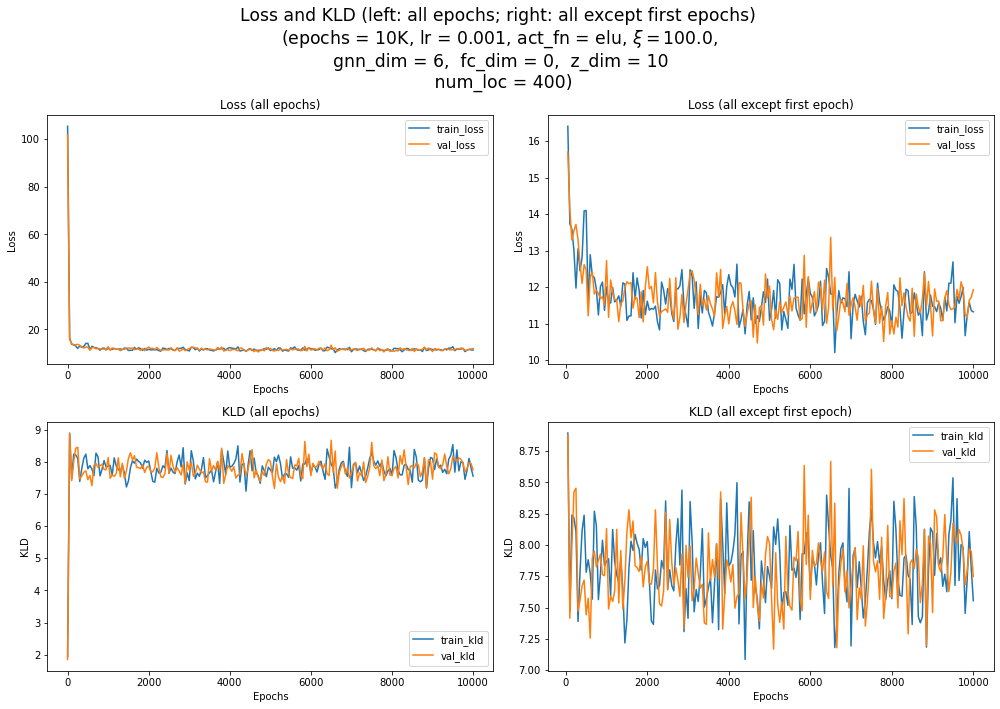

In [23]:
from matplotlib.ticker import MaxNLocator

# Loss plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0, 0].plot(xs, train_losses, label='train_loss')
axes[0, 0].plot(xs, val_losses, label='val_loss')
axes[0, 1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[0, 1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0, 0].set_title('Loss (all epochs)')
axes[0, 1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_xlabel('Epochs')
    axes[0, i].legend()
    
# KLD plots
xs = np.arange(len(train_klds))*ARGS.eval_frequency
axes[1, 0].plot(xs, train_klds, label='train_kld')
axes[1, 0].plot(xs, val_klds, label='val_kld')
axes[1, 1].plot(xs[1:], train_klds[1:], label='train_kld')
axes[1, 1].plot(xs[1:], val_klds[1:], label='val_kld')
axes[1, 0].set_title('KLD (all epochs)')
axes[1, 1].set_title('KLD (all except first epoch)')

for i in range(2): 
    axes[1, i].set_ylabel('KLD')
    axes[1, i].set_xlabel('Epochs')
    axes[1, i].legend()

fig.suptitle(f'Loss and KLD (left: all epochs; right: all except first epochs) \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

loss_kld_path = FIG_PATH / 'loss_kld_figures'
loss_kld_path.mkdir(exist_ok=True)
fig.savefig(loss_kld_path / f'{model_name}.jpg', dpi=300)

In [24]:
MODEL_PATH = Path.cwd() / 'models'
MODEL_PATH.mkdir(exist_ok=True)

SAVE_MODEL = True

model_name = MODEL_PATH / '1DGP_VGAE_L2G'

if SAVE_MODEL:
    model_name.mkdir(exist_ok=True)
    model.save_params(model_name, params)
    print(f'Saved to path: {model_name}')
else:
    print('Did not save model.')

Saved to path: /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/models/1DGP_VGAE_L2G


/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/Users/

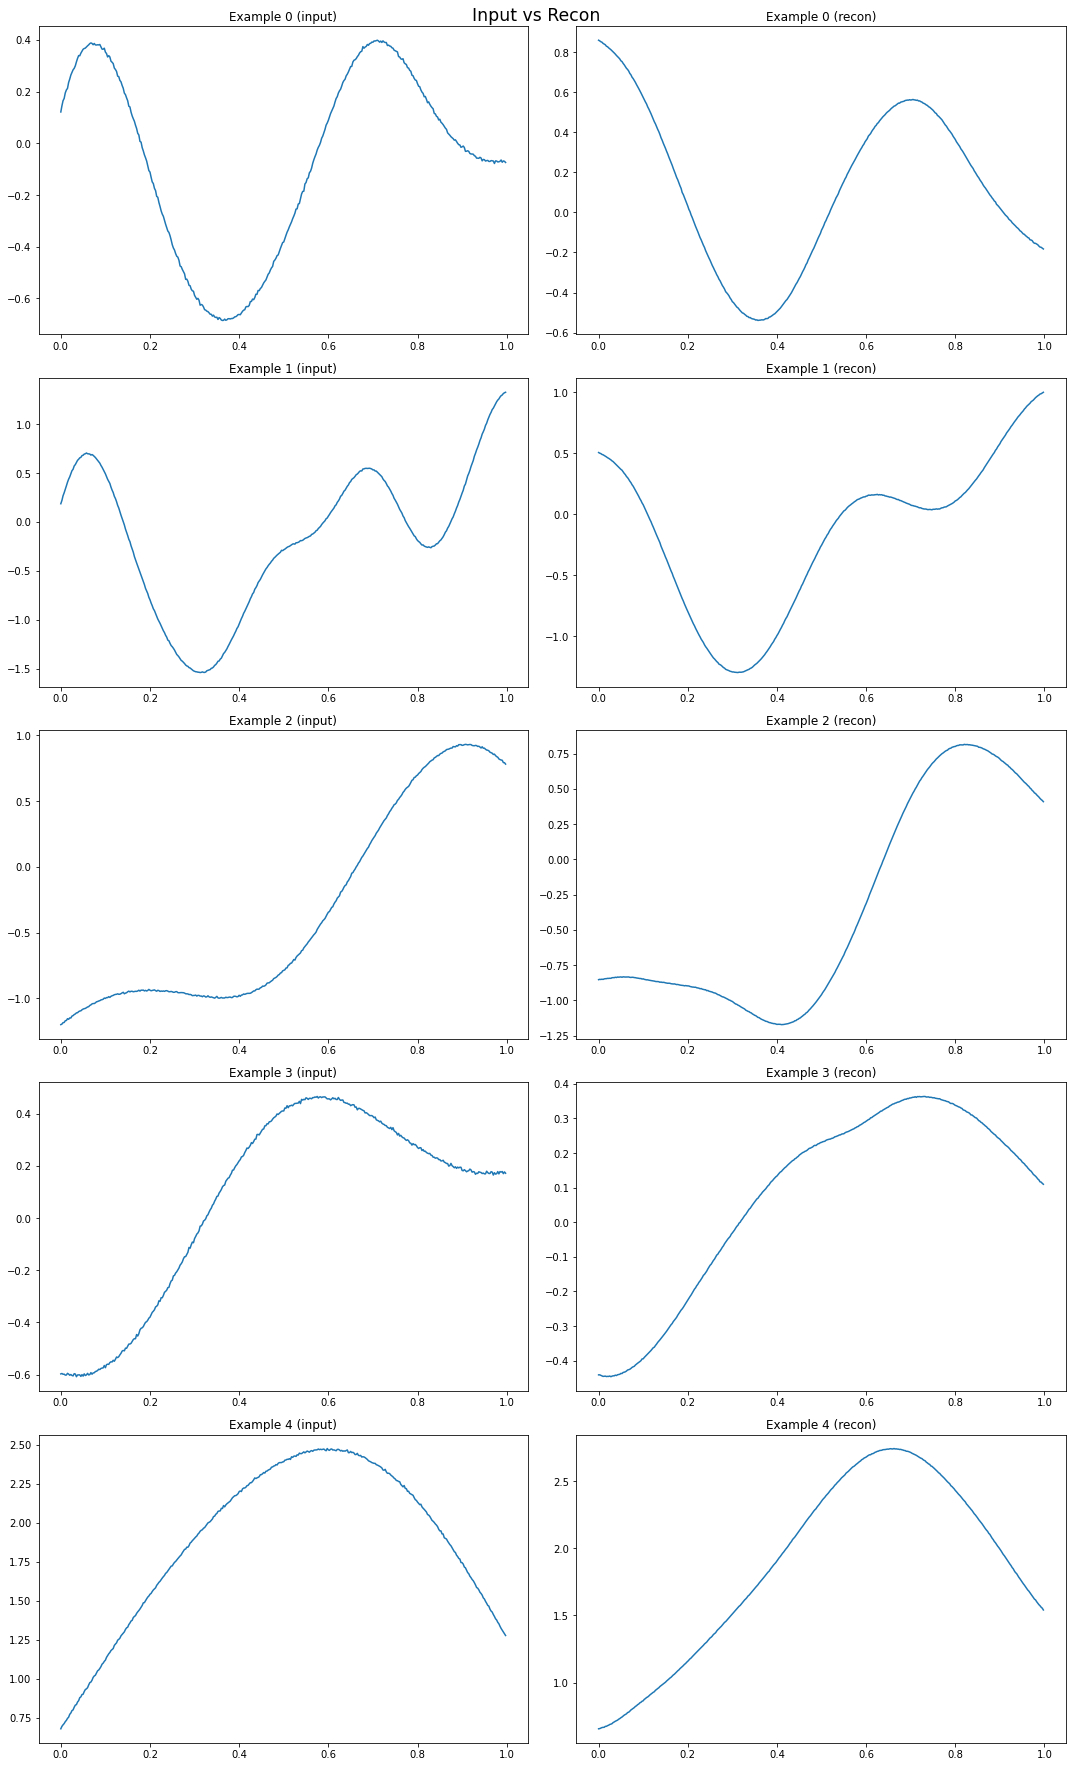

In [25]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

num_to_plot = 5
fig, axes = plt.subplots(num_to_plot, 2, figsize=(15, 25))

original_data = graph_batched_val_data[0]

outputs = net.apply(params, rng_recon, original_data)
recon_data = outputs.output
recon_data = jnp.reshape(recon_data, (ARGS.batch_size, GP1D_ARGS.num_locations))

for i in range(num_to_plot):
    original_gp = jnp.ravel(jraph.unbatch(original_data)[i].nodes)
    recon_gp = jnp.ravel(recon_data[i])

    axes[i, 0].plot(X, original_gp)
    axes[i, 1].plot(X, recon_gp)
    
    axes[i, 0].set_title(f'Example {i} (input)')
    axes[i, 1].set_title(f'Example {i} (recon)')

fig.suptitle(f'Input vs Recon', fontsize='xx-large')

plt.tight_layout()
plt.show()

input_v_recon_path = FIG_PATH / 'recon_figures'
input_v_recon_path.mkdir(exist_ok=True)
fig.savefig(input_v_recon_path / f'{model_name}.jpg', dpi=300)

In [26]:
from functools import partial

decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
decoder_params = {}
for full_key_name in decoder_params_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    decoder_params[key_name] = params[full_key_name]
    
GP1D_ARGS.decoder_params = decoder_params

decoder_net_fn = partial(decoder,
                         graph=BASE_GRAPH,
                         hidden_fc_dim=ARGS.hidden_fc_dim,
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         batch_size=1,
                         num_nodes=GP1D_ARGS.num_locations)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [27]:
def decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z))
    numpyro.deterministic('f', vgae_out)

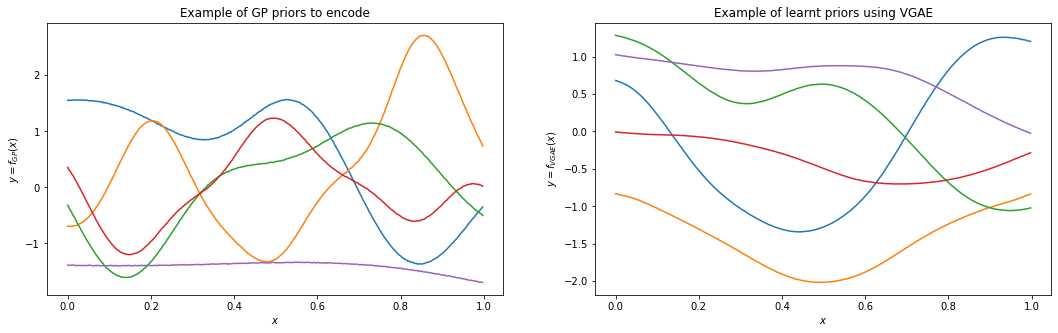

In [28]:
# Rough comparison of the shape of GP draws with learnt VGAE priors.

# Drawing VGAE priors.
RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)
vgae_draws = Predictive(
  decoder_predictive_model, num_samples=10)(vgae_sample_rng)['f']
vgae_draws = vgae_draws[:,:400]

# Plotting the GP draws and VGAE draws.
_, ax = plt.subplots(1, 2, figsize=(18, 5))

plotting.plot_gp_draws(X, gp_draws, num_draws_to_plot=5, 
                     ax=ax[0], title='Example of GP priors to encode', y_label='$y=f_{GP}(x)$')

plotting.plot_gp_draws(X, vgae_draws, num_draws_to_plot=5, 
                     ax=ax[1], title='Example of learnt priors using VGAE', y_label='$y=f_{VGAE}(x)$', )

plt.show()

In [29]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY = jax.random.PRNGKey(0)

RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples)(vgae_rng)['f']
vgae_draws = vgae_draws[:,:400]

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

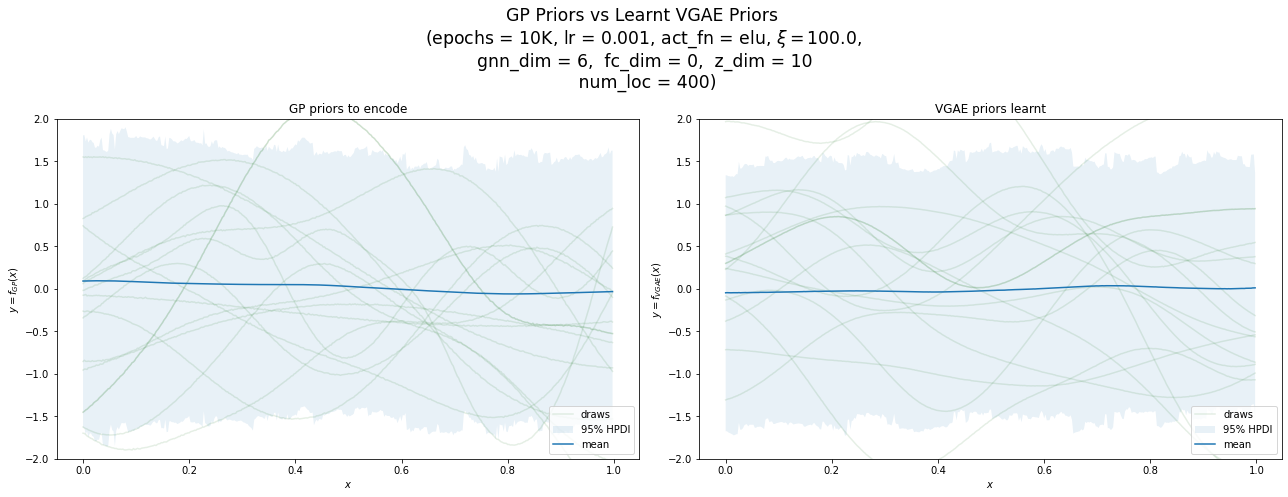

In [30]:

# Plotting the GP draws and VGAE draws.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, mean_vgae, hpdi_vgae,
    lines_alpha_vgae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VGAE priors learnt',
    y_label='$y=f_{VGAE}(x)$')

fig.suptitle(f'GP Priors vs Learnt VGAE Priors \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

estimate_plot_path = FIG_PATH / 'estimate_figures'
estimate_plot_path.mkdir(exist_ok=True)
fig.savefig(estimate_plot_path / f'{model_name}.jpg', dpi=300)

# Plots save

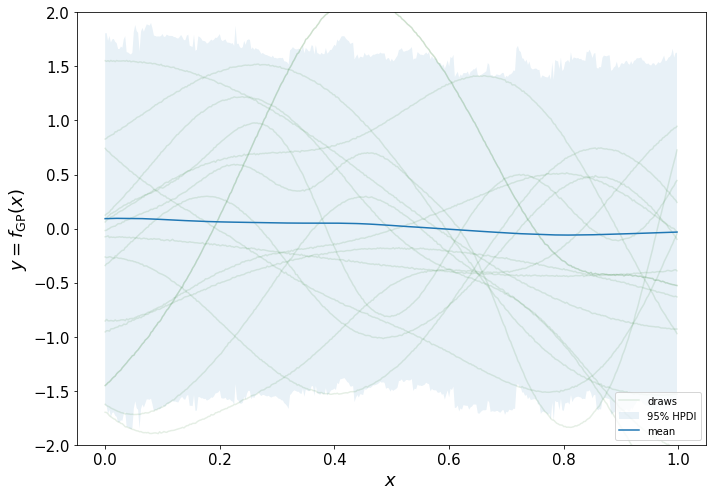

In [31]:
# Plotting the GP draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('GP priors to be learnt', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{GP}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / '1DGP_priors_GP.jpg', dpi=300)

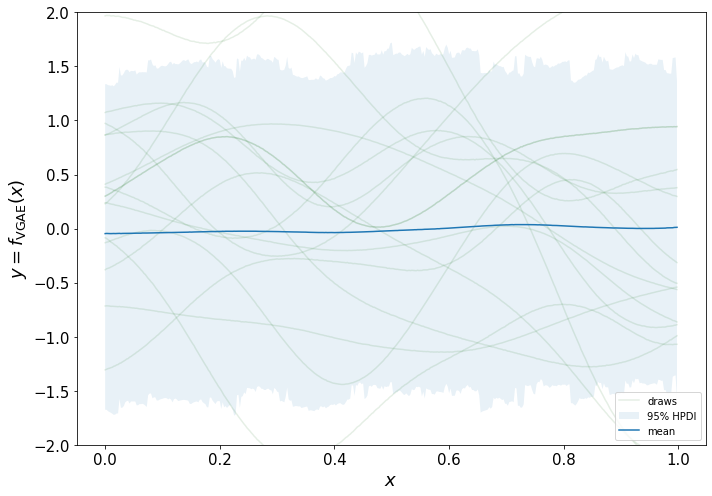

In [32]:
# Plotting the GP draws and VGAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, 
    mean_vgae, hpdi_vgae,lines_alpha_vgae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VGAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VGAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / '1DGP_priors_VGAE.jpg', dpi=300)

# Inference on Observed Data

In [33]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(decoder_params, z))
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [34]:
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))  # THIS WAS OUR CHOICE
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(21))

RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(22))

# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# Choose indices of datapoints for inference.
obs_locations = [
  jnp.array([137, 321]),  # 2 observed datapoints [134, 321] works but that's because PriorVAE fcked up
  jnp.array([89, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 137, 275, 314, 380]),  # 6 observed datapoints
]
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([41, 85, 137, 275, 314, 380]),  # 6 observed datapoints
# ]

x_obs = X[obs_locations[-1]]
y_obs = jnp.squeeze(y_draw[obs_locations[-1]])

In [35]:
# # RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))  # THIS WAS OUR CHOICE
# # RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(12))
# # RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# # RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# # RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(22))

# # Generate true data and observed dataset to infer
# draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
#   gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
# gp_draw = draws['f'].T  # True data
# y_draw = draws['y'].T  # True data + noise

# assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# # Choose indices of datapoints for inference.
# # obs_locations = [
# #   jnp.array([122, 321]),  # 2 observed datapoints
# #   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
# #   jnp.array([71, 85, 111, 291, 314, 380]),  # 6 observed datapoints
# # ]
# # obs_locations = [
# #   jnp.array([122, 321]),  # 2 observed datapoints
# #   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
# #   jnp.array([71, 85, 147, 291, 314, 380]),  # 6 observed datapoints
# # ]
# # obs_locations = [
# #   jnp.array([122, 321]),  # 2 observed datapoints
# #   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
# #   jnp.array([41, 85, 137, 275, 314, 380]),  # 6 observed datapoints
# # ]
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([89, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([71, 85, 137, 275, 314, 380]),  # 6 observed datapoints
# ]

# x_obs = X[obs_locations[-1]]
# y_obs = jnp.squeeze(y_draw[obs_locations[-1]])

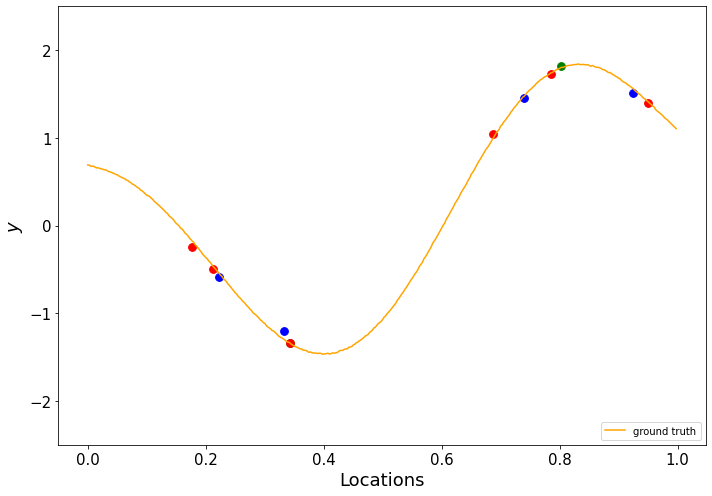

In [36]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(X, gp_draw, label='ground truth', color='orange')
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.scatter(X[obs_locations[0]], jnp.squeeze(y_draw[obs_locations[0]]), color='green', label='observed data', s=60)
ax.scatter(X[obs_locations[1]], jnp.squeeze(y_draw[obs_locations[1]]), color='blue', label='observed data', s=60)
ax.scatter(X[obs_locations[2]], jnp.squeeze(y_draw[obs_locations[2]]), color='red', label='observed data', s=60)

plt.tight_layout()
plt.show()

# fig.savefig(PUBLICATION_PATH / f'1DGP_inference_00.jpg', dpi=300)

In [37]:
mean_post_preds_list = []
hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []
mcmc_objs = []


RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgae_mcmc_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    mcmc_objs.append(mcmc)

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 60.50933909416199
Running chain for n_obs = 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 33.66146373748779
Running chain for n_obs = 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 45.14658999443054


In [38]:
def compute_ess(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all effects : " + str(round(r)))
    
for mcmc in mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 1541
Average ESS for all effects : 1539
Average ESS for all effects : 1793


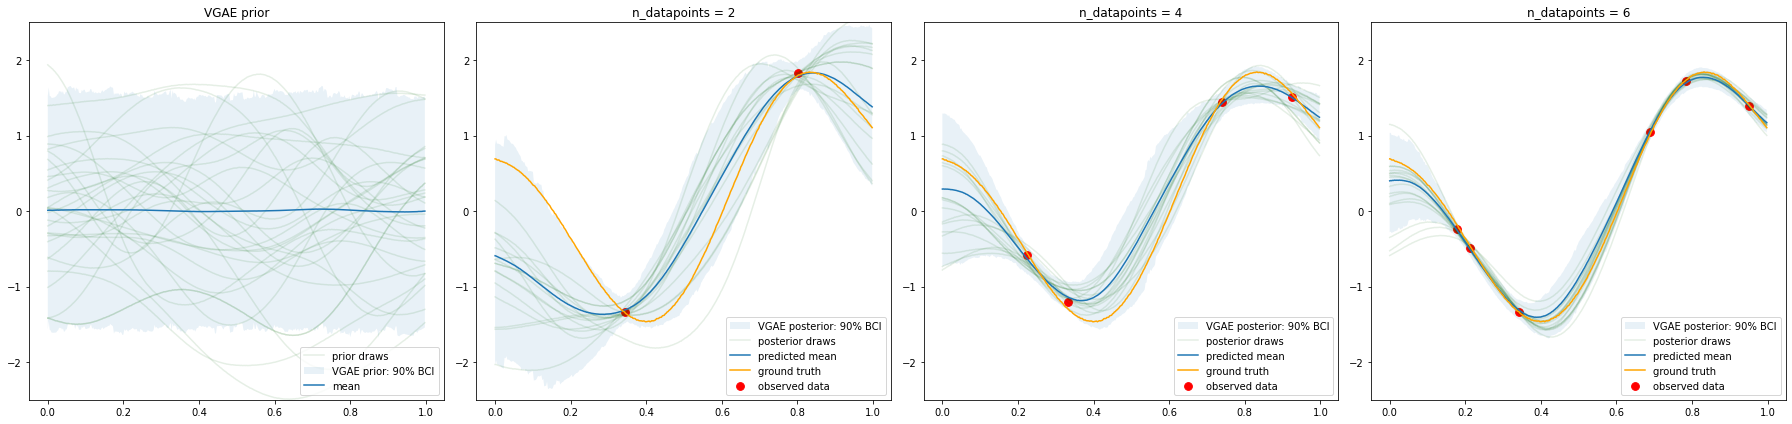

In [194]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VGAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VGAE prior: 90% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VGAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

In [195]:
print(ARGS)

Args(batch_size=100, loss_fn=<function compute_mse_loss at 0x172c8e040>, epochs=10000, eval_frequency=50, learning_rate=0.001, xi=100.0, hidden_gnn_dim=6, hidden_fc_dim=0, latent_dim=10, output_dim=1, act_fn=<CompiledFunction of <function elu at 0x15a0970d0>>)


In [196]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (2) = 0.40928539633750916
mse_vgae (4) = 0.0745651125907898
mse_vgae (6) = 0.011357368901371956


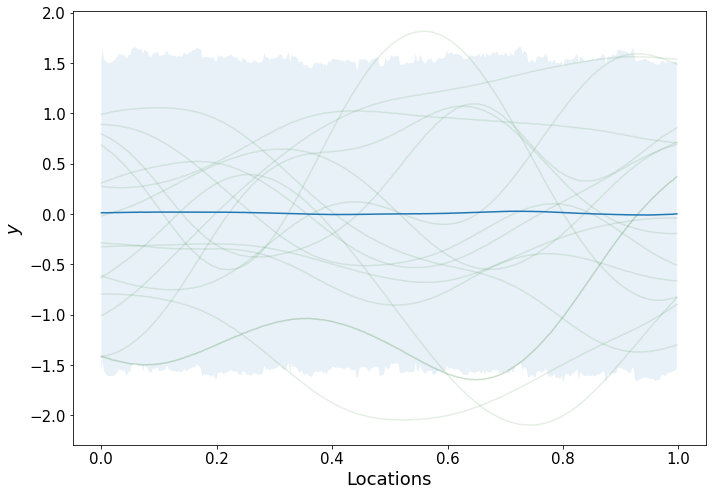

In [197]:
# Plotting results after inference using MCMC.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    ax.plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
ax.plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
ax.fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 90% BCI')
ax.plot(X, mean_prior_pred, label='mean')
# ax.set_title('VAE prior')

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show();

fig.savefig(PUBLICATION_PATH / '1DGP_inference_1.jpg', dpi=300)

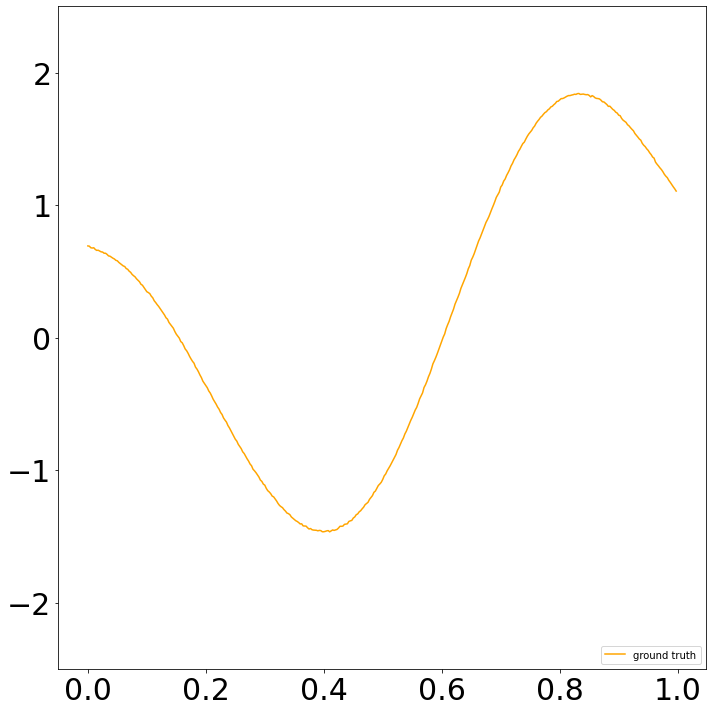

In [198]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(X, gp_draw, label='ground truth', color='orange')
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

# ax.set_xlabel('Locations', fontsize=18)
# ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=30)
    

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / f'1DGP_inference_00.jpg', dpi=300)

n_datapoints = 2


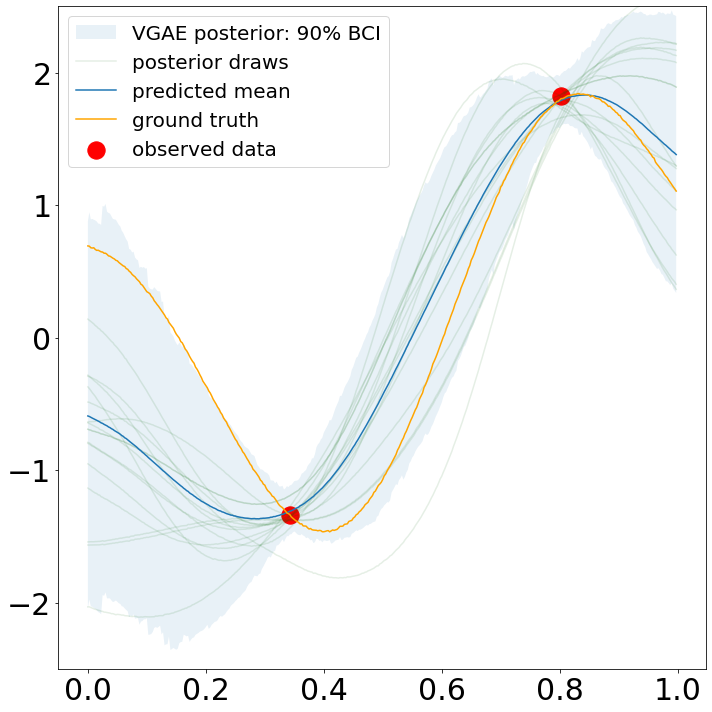

n_datapoints = 4


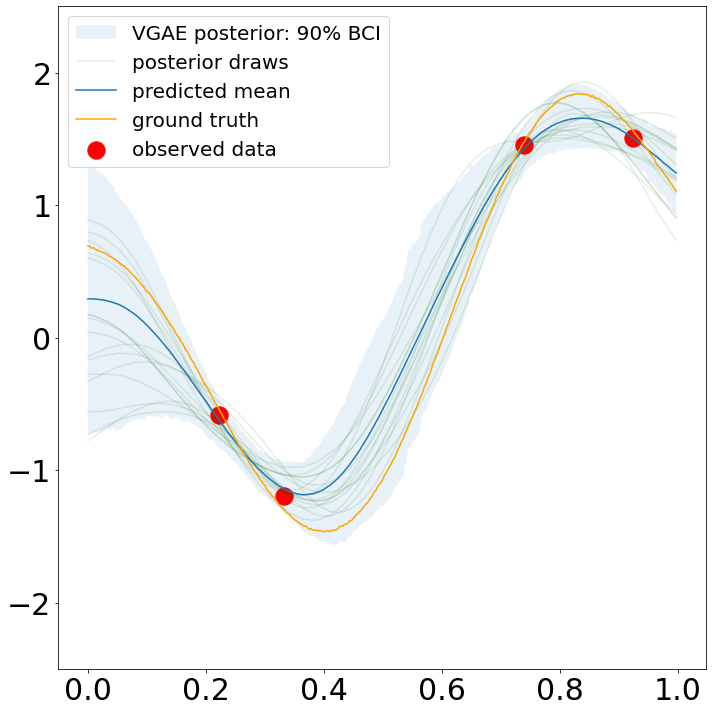

n_datapoints = 6


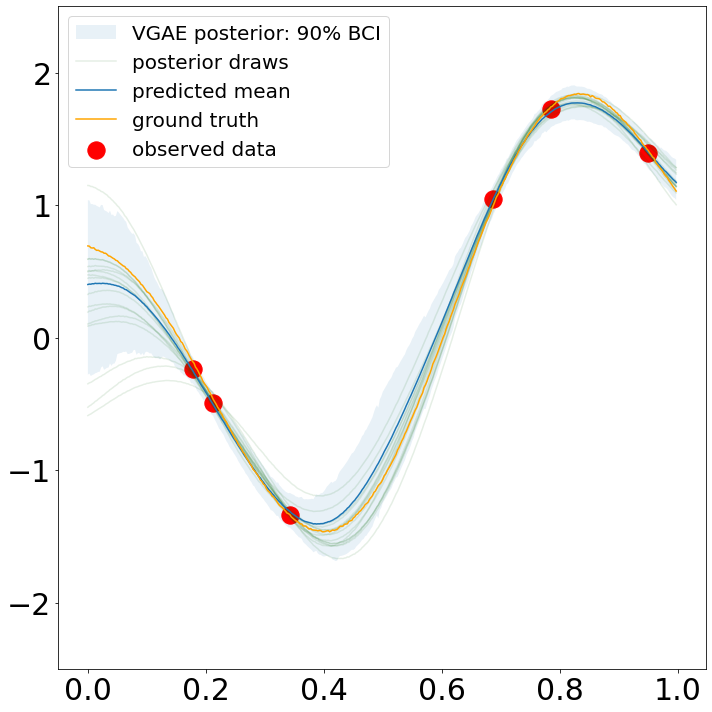

In [199]:
# Plotting VGAE posterior predictive
num_draws_to_plot = 15
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    ax.fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=300)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    # ax.set_xlabel('Locations', fontsize=18)
    # ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    plt.legend(fontsize=20, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    fig.savefig(PUBLICATION_PATH / f'1DGP_inference_VGAE_{idx+2}.jpg', dpi=300)

In [45]:
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(44), 3)
RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(1), 3)
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(16), 3)

gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1000)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

vgae_predictive = Predictive(vgae_mcmc_predictive_model, num_samples=1000)
vgae_draws = vgae_predictive(vgae_rng)['f']
vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)

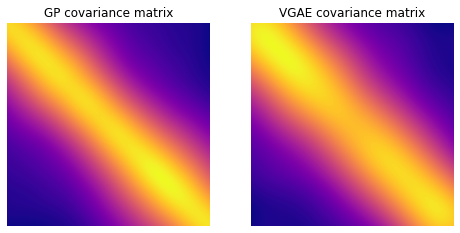

In [61]:
m_vgae = np.cov(np.transpose(vgae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vgae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VGAE covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

### Baseline PriorVAE

Priors learnt by the VAE

In [47]:
vae_model_name = '1DGP_PriorVAE_baseline'
model_path = ROOT_PATH / 'models' / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VAE model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/models/1DGP_PriorVAE_baseline


In [48]:
vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=30,
        hidden2_dim=35,
        output_dim=GP1D_ARGS.num_locations
    )
))

def vae_decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([10]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    numpyro.deterministic('f', vae_out)

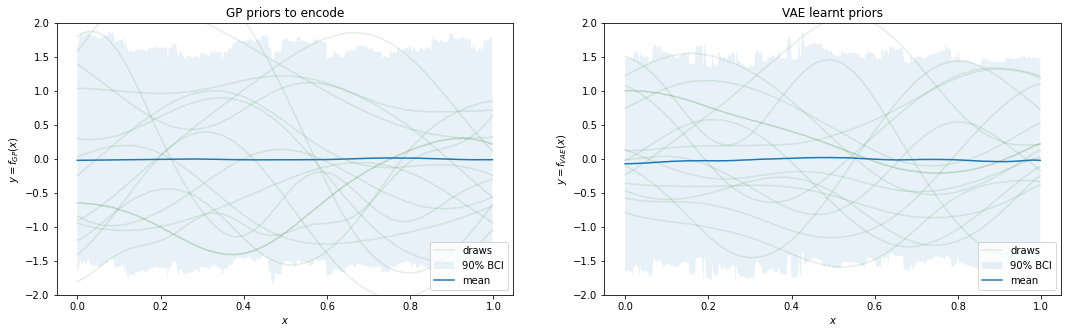

In [200]:
# Comparing distribution of GP draws with learnt VAE priors.

RNG_KEY, rng_gp, rng_vae = jax.random.split(jax.random.PRNGKey(5), 3)
gp_draws = dataset_1dgp.generate_gp_batch(
    rng_gp, X, batch_size=1000, kernel=GP1D_ARGS.kernel)  # batch_size is equivalent to `num_samples`.
vae_draws = Predictive(vae_decoder_predictive_model, num_samples=1000)(rng_vae)['f']

# Computing the mean and HPDI of the GP draws and VAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vae_draws = vae_draws[~np.isnan(vae_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

# Plotting the GP draws and VAE draws.
_, axes = plt.subplots(1, 2, figsize=(18, 5))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vae_draws, mean_vae, hpdi_vae,
    lines_alpha_vae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VAE learnt priors', y_label='$y=f_{VAE}(x)$')

plt.show()

In [50]:
VAE_PUBLICATION_PATH = FIG_PATH / 'VAE_print'
VAE_PUBLICATION_PATH.mkdir(exist_ok=True)

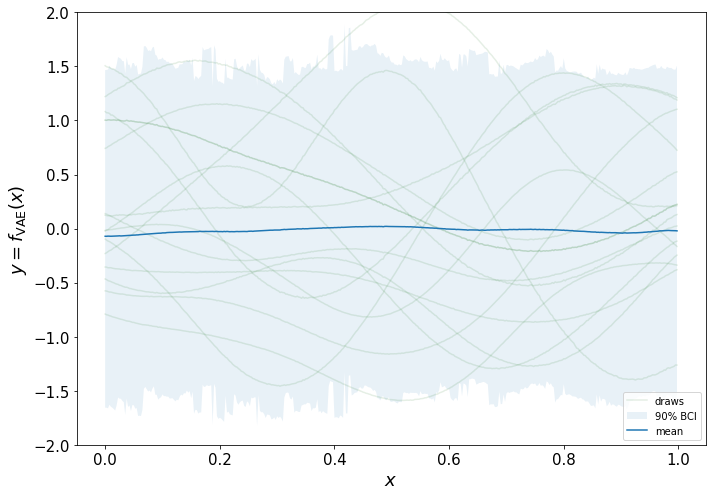

In [201]:
# Plotting the GP draws and VAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vae_draws, 
    mean_vae, hpdi_vae,lines_alpha_vae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

fig.savefig(VAE_PUBLICATION_PATH / '1DGP_priors_VAE.jpg', dpi=300)

In [202]:
def vae_model_mcmc(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([10]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [53]:
vae_mean_post_preds_list = []
vae_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []
vae_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vae_model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vae_mcmc_objs.append(mcmc)

    predictions = Predictive(vae_model_mcmc, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.7814841270446777
Running chain for n_obs = 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.6206393241882324
Running chain for n_obs = 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.8154070377349854


In [54]:
for mcmc in vae_mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 815
Average ESS for all effects : 1006
Average ESS for all effects : 1451


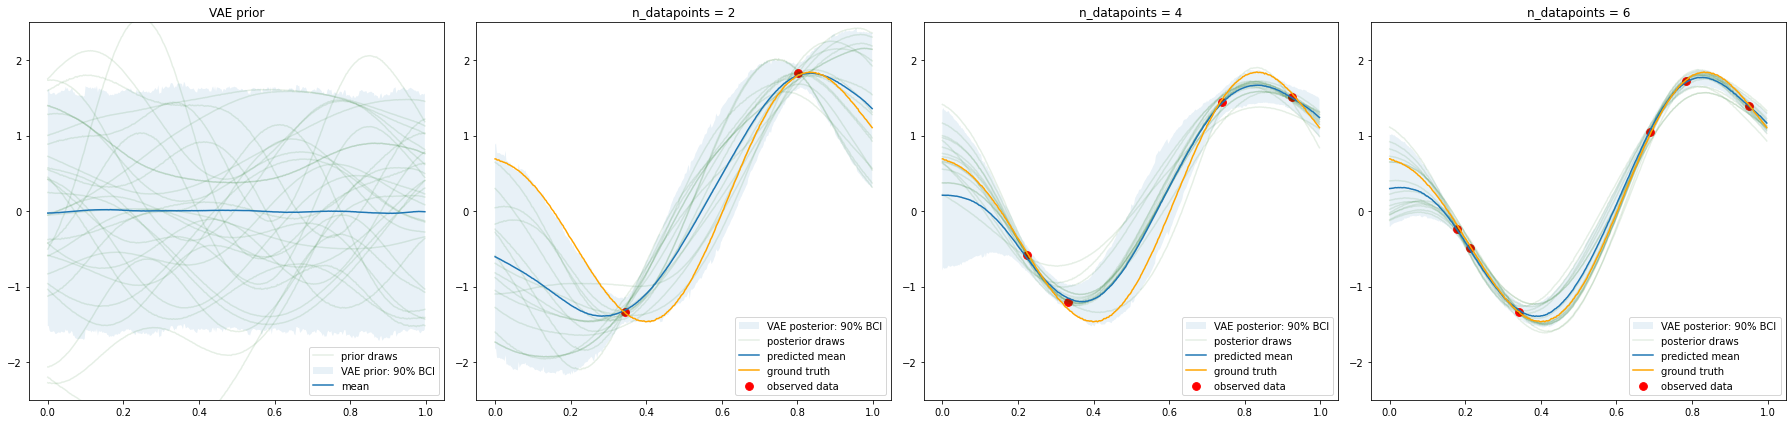

In [203]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 90% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

n_datapoints = 2


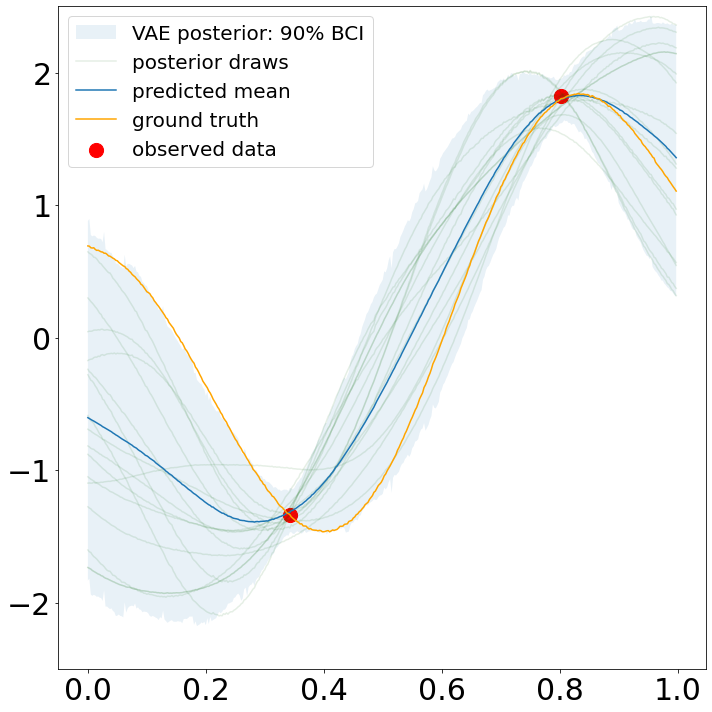

n_datapoints = 4


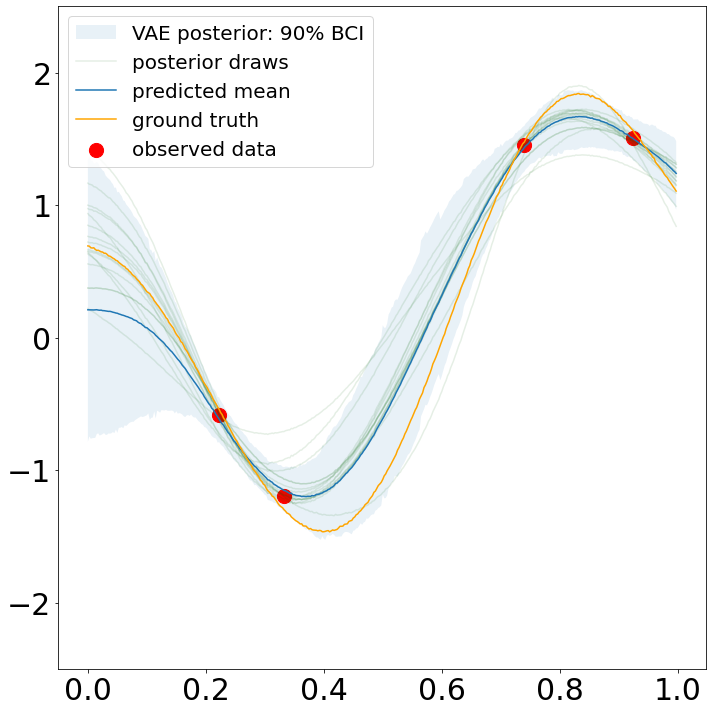

n_datapoints = 6


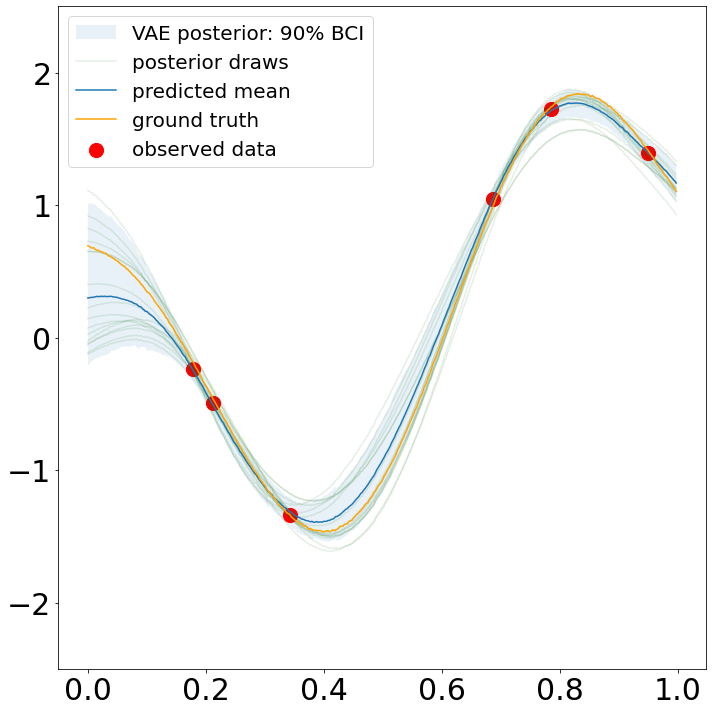

In [204]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    ax.fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=200)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    # ax.set_xlabel('Locations', fontsize=18)
    # ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    plt.legend(fontsize=20, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    fig.savefig(VAE_PUBLICATION_PATH / f'1DGP_inference_PriorVAE_{idx+2}.jpg', dpi=300)

In [57]:
# RNG_KEY, gp_rng, vae_rng = jax.random.split(jax.random.PRNGKey(44), 3)
RNG_KEY, gp_rng, vae_rng = jax.random.split(jax.random.PRNGKey(1), 3)
# RNG_KEY, gp_rng, vae_rng = jax.random.split(jax.random.PRNGKey(16), 3)

gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1000)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

vae_predictive = Predictive(vae_model_mcmc, num_samples=1000)
vae_draws = vae_predictive(vae_rng)['f']
vae_draws = dataset_1dgp.remove_nans_from_gp(vae_draws)

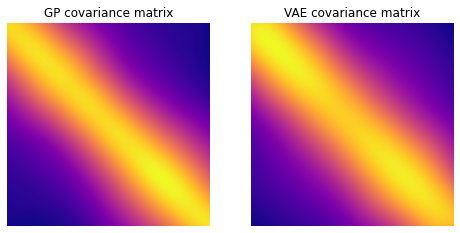

In [58]:
m_vae = np.cov(np.transpose(vae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VAE covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

# Compare both methods

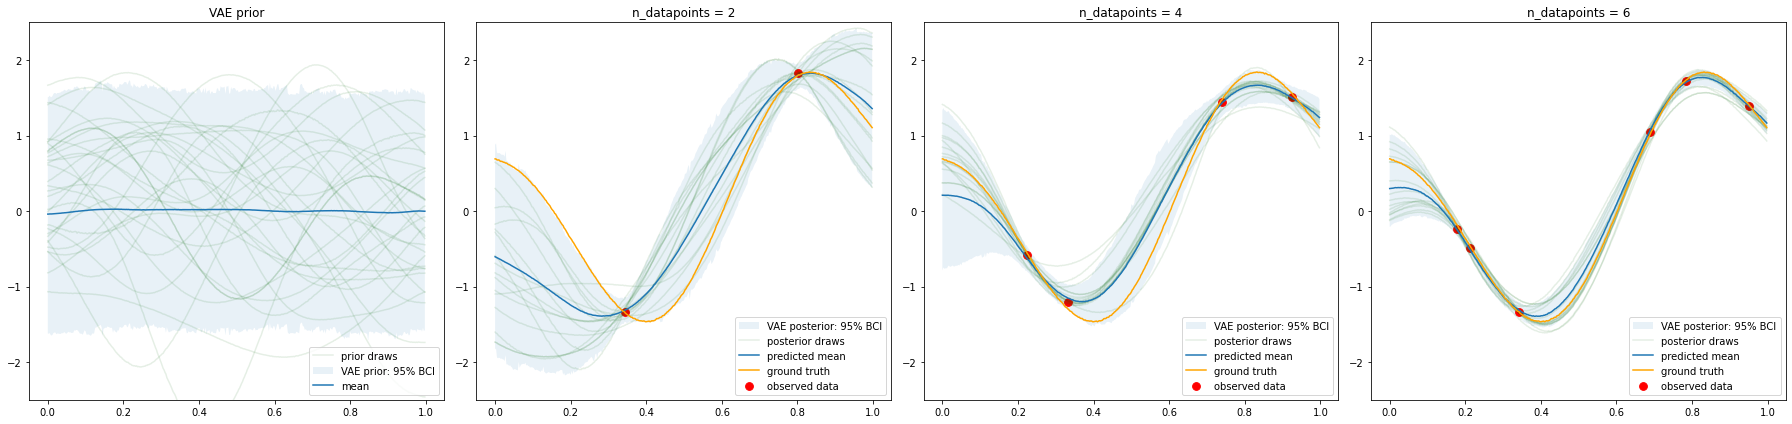

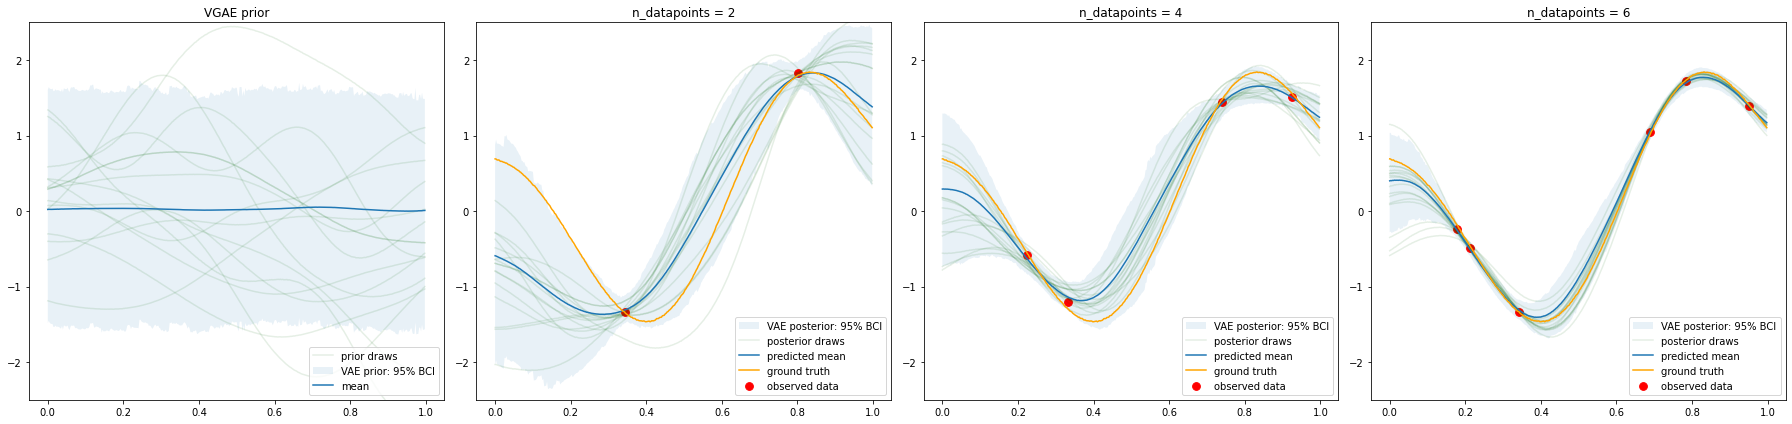

In [59]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

In [60]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')
    
print()

for idx, mean in enumerate(vae_mean_post_preds_list):
    mse_vae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mse_vae}')

mse_vgae (2) = 0.40928539633750916
mse_vgae (4) = 0.0745651125907898
mse_vgae (6) = 0.011357368901371956

mse_vae (2) = 0.4198857545852661
mse_vae (4) = 0.06584762781858444
mse_vae (6) = 0.014181509613990784


# MSE range

In [193]:
for idx, preds in enumerate(predictions_list):
    mse_posterior = np.mean((preds - gp_draw.T)**2, axis=1)
    mean_mse = mse_posterior.mean()
    hpdi_mse = hpdi(mse_posterior, 0.89)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mean_mse} {hpdi_mse}')
    
print()

for idx, preds in enumerate(vae_predictions_list):
    mse_posterior = np.mean((preds - gp_draw.T)**2, axis=1)
    mean_mse = mse_posterior.mean()
    hpdi_mse = hpdi(mse_posterior, 0.89)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mean_mse} {hpdi_mse}')

mse_vgae (2) = 0.669644296169281 [0.01833061 1.3436639 ]
mse_vgae (4) = 0.16362446546554565 [0.00460265 0.32887867]
mse_vgae (6) = 0.03898387402296066 [0.0011124  0.08806518]

mse_vae (2) = 0.6571306586265564 [0.02034092 1.2828357 ]
mse_vae (4) = 0.14626836776733398 [0.00452172 0.32879725]
mse_vae (6) = 0.03258158266544342 [0.00276162 0.06619029]


In [150]:
bci_1 = np.quantile(avg_msessss, 0.05, axis=0)
bci_2 = np.quantile(avg_msessss, 0.95, axis=0)
print(np.array([bci_1, bci_2]))

[0.1007847 1.6537056]
